In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Moving Average with CNN

In [3]:
from scipy.signal import lfilter
from matplotlib import pyplot as plt

In [4]:
import numpy as np

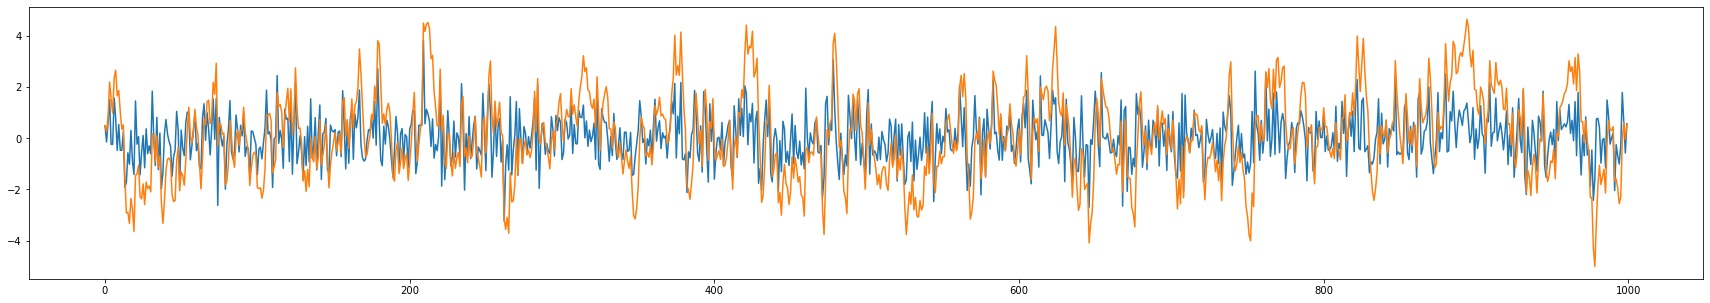

In [5]:
np.random.seed(42)
# filter_coefs = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
# filter_coefs = (filter_coefs/len(filter_coefs))
alpha = 0.8
N_coefs = 20
filter_coefs = np.power(alpha, np.abs(list(range(0, N_coefs)))) #[::-1]
X = np.random.normal(0, 1, 1000)
y_MA = lfilter(filter_coefs, [1], X)
plt.figure(figsize=(30, 5))
plt.plot(X)
plt.plot(y_MA)

Text(0.5, 1.0, 'Respuesta al impulso MA(20)')

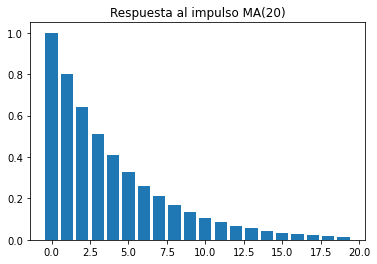

In [6]:
impulse = np.zeros(20)
impulse[0] = 1
impulse_response = lfilter(filter_coefs, [1], impulse)
plt.bar(range(len(impulse_response)), impulse_response)
plt.title('Respuesta al impulso MA(20)')

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D

In [8]:
def get_CNN_model():
    model = Sequential()
    model.add(Conv1D(filters=1, kernel_size=len(filter_coefs), strides=1, input_shape=(1000, 1)))
    model.compile(optimizer='adam', loss='mse')
    return model

In [9]:
model_CNN = get_CNN_model()

In [23]:
model_CNN.fit(X.reshape(1, -1, 1), y_MA[len(filter_coefs)-1:].reshape(1, -1, 1), epochs=500, verbose=0)

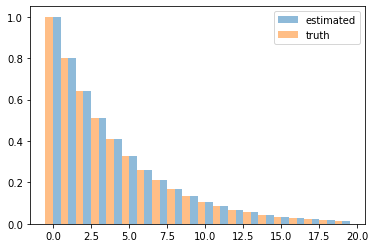

In [24]:
plt.bar(range(len(filter_coefs)), model_CNN.layers[0].get_weights()[0].flatten()[::-1], alpha=0.5, width=0.5, align='edge', label='estimated')
plt.bar(range(len(filter_coefs)), filter_coefs, alpha=0.5, width=-0.5, align='edge', label='truth')
plt.legend()

In [25]:
prediction_CNN = model_CNN.predict(X.reshape(1, -1, 1))

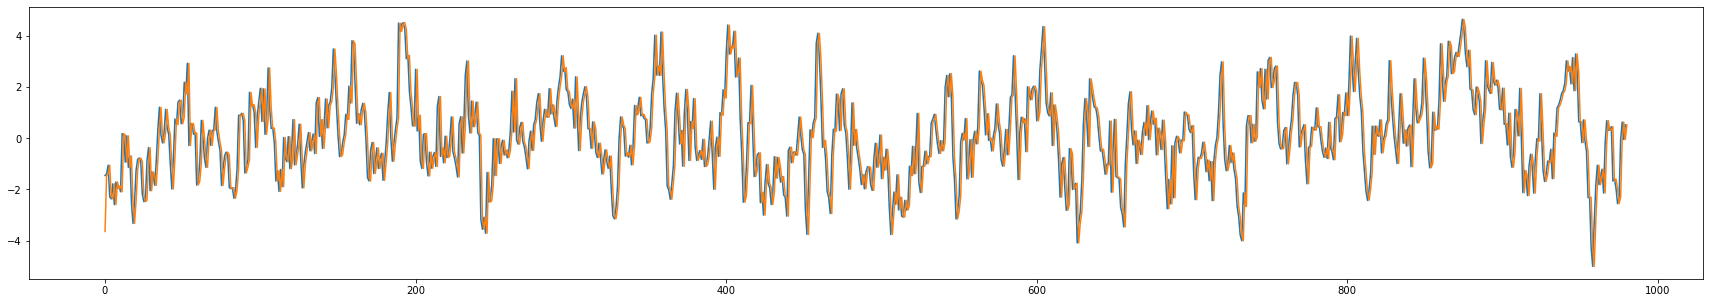

In [111]:
plt.figure(figsize=(30, 5))

plt.plot(y_MA[20:])
plt.plot(prediction_CNN.flatten())

# AR with RNN

In [34]:
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense

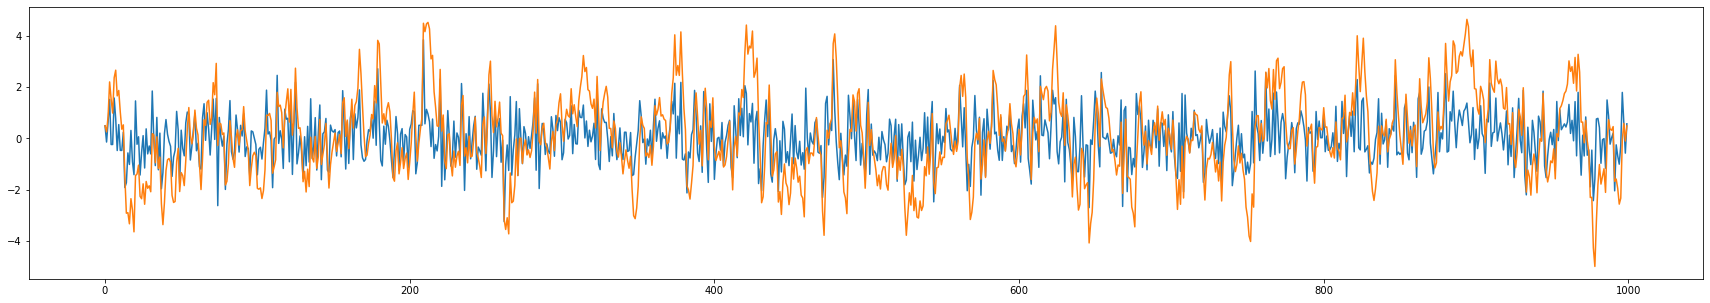

In [35]:
# np.random.seed(42)
# X = np.random.normal(0, 1, 1000)
y_AR1 = lfilter([1], [1, -alpha], X)
plt.figure(figsize=(30, 5))
plt.plot(X)
plt.plot(y_AR1)

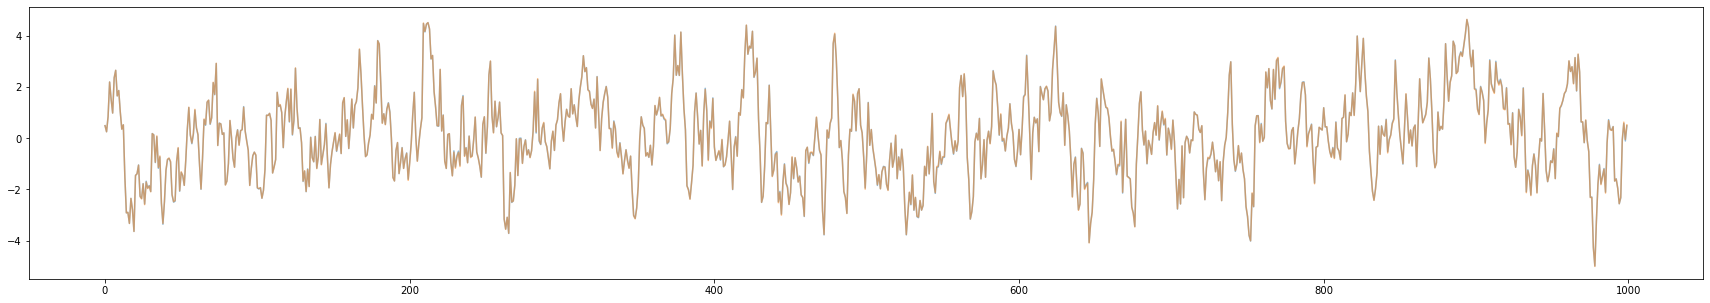

In [36]:
plt.figure(figsize=(30, 5))
plt.plot(y_AR1, alpha=0.5)
plt.plot(y_MA, alpha=0.5)

Text(0.5, 1.0, 'Respuesta al impulso AR(1)')

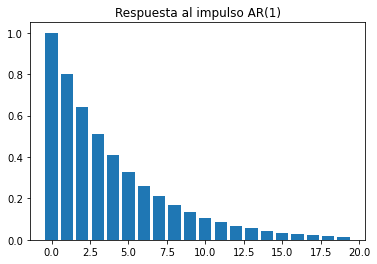

In [37]:
impulse = np.zeros(20)
impulse[0] = 1
plt.bar(range(len(impulse)), lfilter([1], [1, -alpha], impulse))
plt.title('Respuesta al impulso AR(1)')

In [58]:
def get_RNN_1():
    model_RNN_1 = Sequential()
    model_RNN_1.add(SimpleRNN(1, input_shape=(1000, 1), return_sequences=True, activation='linear', unroll=True))
    model_RNN_1.compile(optimizer='rmsprop', loss='mse')
    return model_RNN_1

In [59]:
model_RNN_1 = get_RNN_1()
model_RNN_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 1000, 1)           3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [40]:
%%time
model_RNN_1.fit(X.reshape(1, -1, 1), y_AR1.reshape(1, -1, 1), epochs=1, verbose=0)
# unroll=True Wall time: 30 s

CPU times: user 24.6 s, sys: 497 ms, total: 25.1 s
Wall time: 25 s


In [42]:
%%time
model_RNN_1.fit(X.reshape(1, -1, 1), y_AR1.reshape(1, -1, 1), epochs=1000, verbose=0)
# unroll=True Wall time: 34.5 s

CPU times: user 23.1 s, sys: 5.81 s, total: 28.9 s
Wall time: 15.5 s


In [44]:
model_RNN_1.layers[0].get_weights()

[array([[0.99950784]], dtype=float32),
 array([[0.799494]], dtype=float32),
 array([-0.00050236], dtype=float32)]

In [47]:
prediction_RNN_1 = model_RNN_1.predict(X.reshape(1, -1, 1)).flatten()

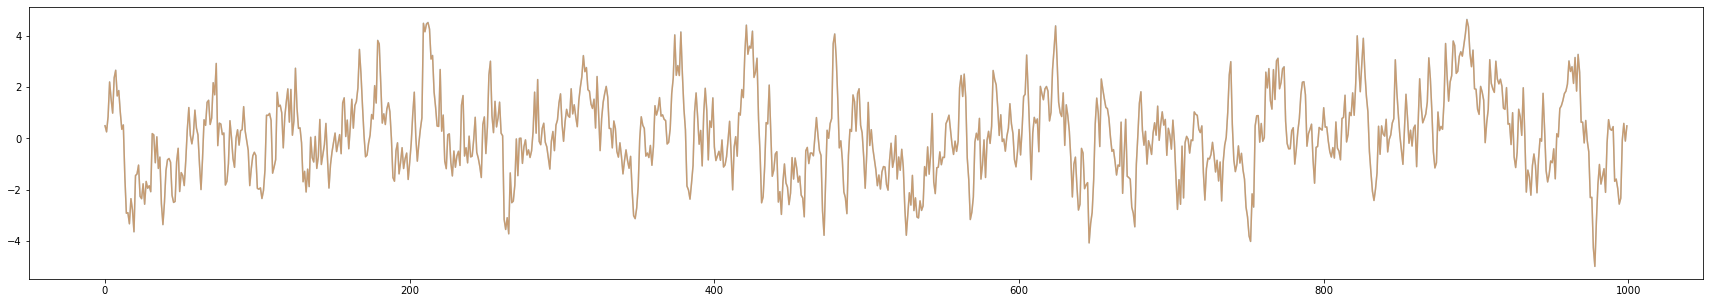

In [54]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR1, alpha=0.5)
plt.plot(prediction_RNN_1, alpha=0.5)

# AR 2

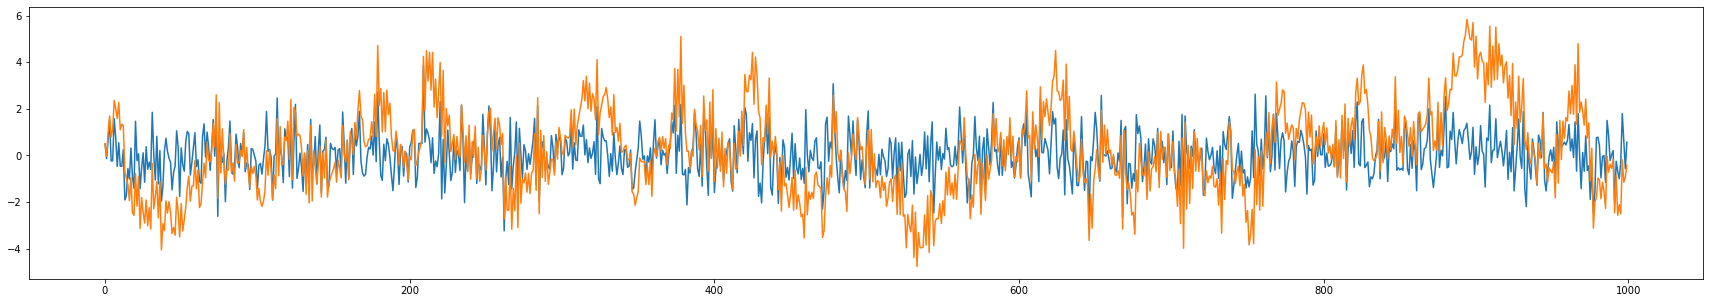

In [57]:
beta=0.1
y_AR2 = lfilter([1], [1, -0.2, -0.7], X)
plt.figure(figsize=(30, 5))
plt.plot(X)
plt.plot(y_AR2)

Text(0.5, 1.0, 'Respuesta al impulso AR(1)')

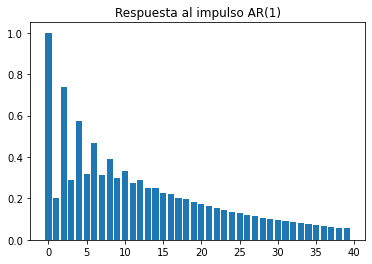

In [126]:
impulse = np.zeros(40)
impulse[0] = 1
plt.bar(range(len(impulse)), lfilter([1], [1, -0.2, -0.7], impulse))
plt.title('Respuesta al impulso AR(1)')

## Solved with CNN

In [100]:
model_CNN_AR = get_CNN_model()
model_CNN_AR.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 981, 1)            21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [121]:
model_CNN_AR.fit(X.reshape(1, -1, 1), y_AR2[len(filter_coefs)-1:].reshape(1, -1, 1), epochs=5000, verbose=0)

In [122]:
prediction_CNN_AR2 = model_CNN_AR.predict(X.reshape(1, -1, 1)).flatten()

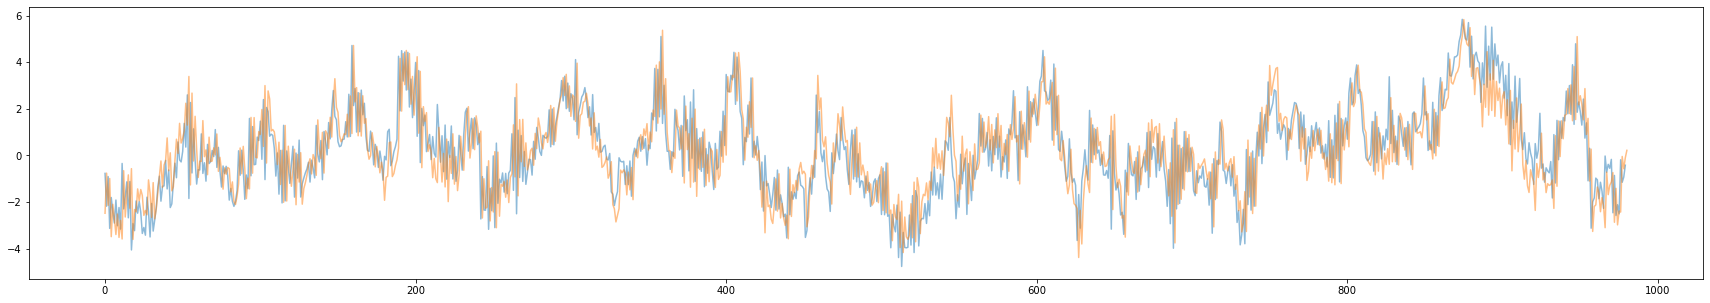

In [124]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR2[20:], alpha=0.5)
plt.plot(prediction_CNN_AR2, alpha=0.5)

# Solved with RNN Anterior

In [60]:
model_RNN_1 = get_RNN_1()
model_RNN_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 1000, 1)           3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [61]:
model_RNN_1.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=1, verbose=0)

In [70]:
%%time
model_RNN_1.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=5000, verbose=0)

CPU times: user 18.6 s, sys: 1.36 s, total: 20 s
Wall time: 14.2 s


In [82]:
model_RNN_1.layers[0].get_weights()

[array([[0.6194555]], dtype=float32),
 array([[0.93693584]], dtype=float32),
 array([0.00090129], dtype=float32)]

In [71]:
prediction_RNN_1_b = model_RNN_1.predict(X.reshape(1, -1, 1)).flatten()

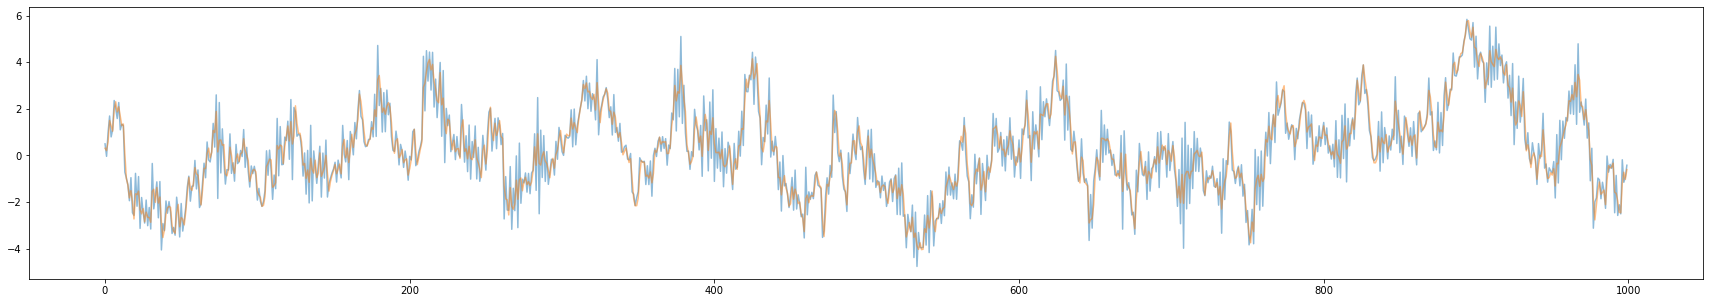

In [72]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR2, alpha=0.5)
plt.plot(prediction_RNN_1_b, alpha=0.5)

## Agregado de neurona

In [65]:
model_RNN_2 = Sequential()
model_RNN_2.add(SimpleRNN(2, input_shape=(1000, 1), return_sequences=True, activation='linear', unroll=True))
model_RNN_2.add(Dense(1, activation='linear'))
model_RNN_2.compile(optimizer='rmsprop', loss='mse')

In [66]:
model_RNN_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 1000, 2)           8         
_________________________________________________________________
dense (Dense)                (None, 1000, 1)           3         
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________


In [67]:
%%time
model_RNN_2.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=5000, verbose=0)

In [84]:
model_RNN_2.get_weights()

[array([[-0.18161155, -0.9188171 ]], dtype=float32),
 array([[ 0.11566273, -0.98967636],
        [-0.7162804 ,  0.08315939]], dtype=float32),
 array([-0.0019684 ,  0.00108563], dtype=float32),
 array([[ 0.5041162],
        [-1.1868366]], dtype=float32),
 array([0.03103462], dtype=float32)]

In [68]:
prediction_RNN_2 = model_RNN_2.predict(X.reshape(1, -1, 1)).flatten()

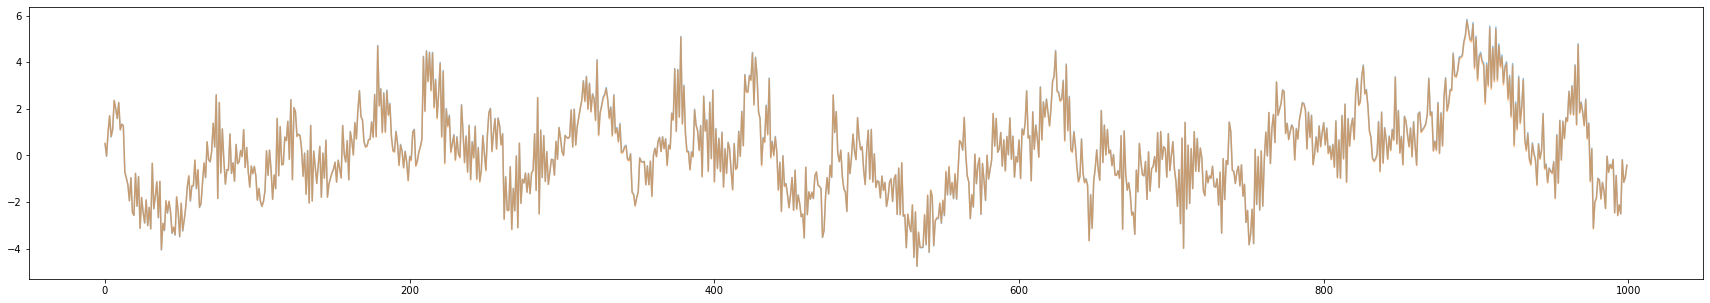

In [69]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR2, alpha=0.5)
plt.plot(prediction_RNN_2, alpha=0.5)

## Stack de RNNs

In [74]:
model_stack = Sequential()
model_stack.add(SimpleRNN(1, input_shape=(1000, 1), return_sequences=True, activation='linear', unroll=True))
model_stack.add(SimpleRNN(1, return_sequences=True, activation='linear', unroll=True))
model_stack.compile(optimizer='rmsprop', loss='mse')

In [79]:
model_stack.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_6 (SimpleRNN)     (None, 1000, 1)           3         
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 1000, 1)           3         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [76]:
%%time
model_stack.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=1, verbose=0)

CPU times: user 59.5 s, sys: 910 ms, total: 1min
Wall time: 1min


In [86]:
%%time
model_stack.fit(X.reshape(1, -1, 1), y_AR2.reshape(1, -1, 1), epochs=2000, verbose=0)

CPU times: user 1min 27s, sys: 7.79 s, total: 1min 35s
Wall time: 1min 8s


In [87]:
model_stack.get_weights()

[array([[1.1725413]], dtype=float32),
 array([[-0.7430852]], dtype=float32),
 array([-0.20055136], dtype=float32),
 array([[0.8528101]], dtype=float32),
 array([[0.9430822]], dtype=float32),
 array([0.09896299], dtype=float32)]

In [88]:
prediction_RNN_stack = model_stack.predict(X.reshape(1, -1, 1)).flatten()

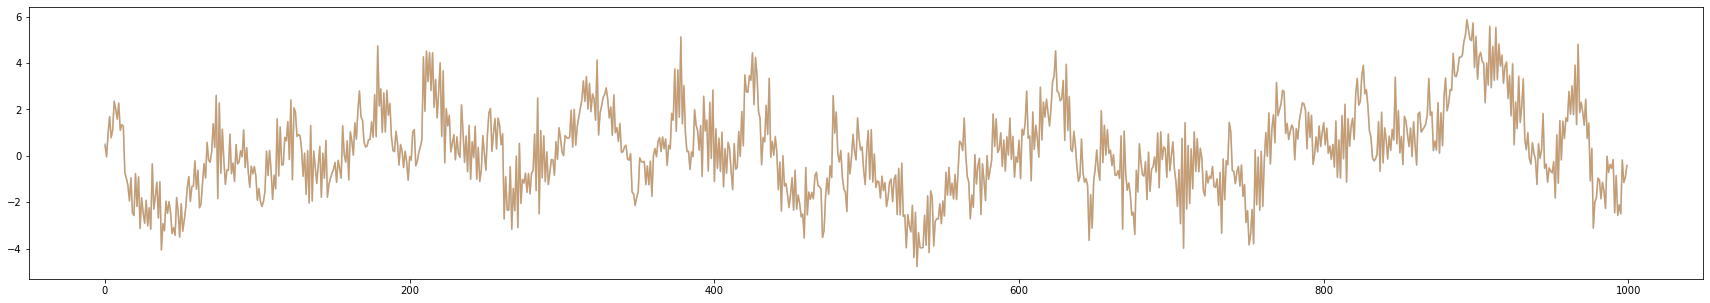

In [94]:
plt.figure(figsize=(30, 5))

plt.plot(y_AR2, alpha=0.5)
plt.plot(prediction_RNN_stack, alpha=0.5)